## Práctica 1
#### Integrantes
* García Elorza Uriel
* Gutiérrez Elizalde Jesús Israel
* Sánchez Velasco Eduardo Leonel

Bibliotecas utilizadas

In [1]:
import numpy as np
import sys
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

#### Pregunta 1
Súper clase para definir un nodo computacional

In [2]:
class Node:
    # Clase nodo
    def __call__(self,x):
        return self.forward(x)

    def __str__(self):
        return str(self.out)

#### Pregunta 2
Definimos la clase del nodo de preactivación con la forma $a(x) = w \cdot x + b$ siendo $w$ los pesos asociados al problema y $b$ el bias

In [3]:
##Clases basicas

class PreActivation(Node):
    # Pre-activación wx+b
    def __init__(self, input_size, output_size):
        self.w = np.random.uniform(0,1,input_size) # Pesos
        self.b = np.random.uniform(0,1) # Bias

    def forward(self, x):
        # Función que activa el nodo
        self.input = x
        self.out = np.dot(self.input,self.w) + self.b # Expresión lineal
        return self

    def backward(self, consumer_grad=1):
        # La función backward recibe el gradiente de los nodos hijos y regresa el gradiente
        self.grad = np.dot(consumer_grad, self.w.T)
        self.grad_w = np.dot(self.input.T ,consumer_grad)
        self.grad_b = np.sum(consumer_grad,axis=0)
        return self  
            


#### Pregunta 3
Definimos la clase del nodo de la función de activación sigmoide $\sigma(x) = \frac{1}{1+e^{-x}}$, se asume que esta clase va a recibir algún tipo de preactivación. Además $\sigma´(x) = \sigma(x)(1-\sigma(x))$

In [4]:
class Sigmoid(Node):
    def __init__(self, node):
        self.preactivacion = node
    def forward(self,x):
        self.input = x
        self.sigmoid = 1 / (1+np.exp(-self.preactivacion.forward(x).out)) # Función Sigmoide
        self.out = np.where(0.5 > self.sigmoid, 0, 1)
        return self
    def backward(self, consumer_grad=1):
        # Gradiente del sigmoide, si no recibe un nodo hijo, multiplica por 1
        self.sigmoid_der = self.sigmoid * (1 - self.sigmoid)
        self.grad = consumer_grad * self.sigmoid_der
        return self.preactivacion.backward(consumer_grad=self.grad)
        


#### Pregunta 4
Definimos la clase para la entropía binaria cruzada $bin(x,y) = -( ylnf(x) + (1-y)lnf(x) )$, misma que se utiliza como función objetivo para la regresión logística. Con derivada $\frac{\partial}{\partial y}bin(x,y) = \begin{cases}
       -\frac{1}{y} \; y = 1 \\
       \frac{1}{1-y} \; e.o.c.\\ 
     \end{cases} $

In [5]:
class BinaryCrossEntropy(Node):
    # Error de clasificación binario
    def __init__(self, node):
        self.activación = node
    def forward(self,x,y):
        # Definido por casos para evitar infinitos innecesarios
        epsilon = sys.float_info.epsilon
        self.pred, self.y = x, y
        if(y == 0):
            self.out = -np.log(1-x.sigmoid+epsilon)
        else:
            self.out = -np.log(x.sigmoid-epsilon)
        return 

    def backward(self):
        if self.y == 1:
            self.grad = -1/self.y
        else:
            self.grad = 1/1-self.y
        return self.activación.backward(consumer_grad=self.grad) 

#### Pregunta 5
Utilizando los nodos definidos anteriormente, vamos a realizar una regresión logística para clasificar un conjunto de datos

(700, 2)


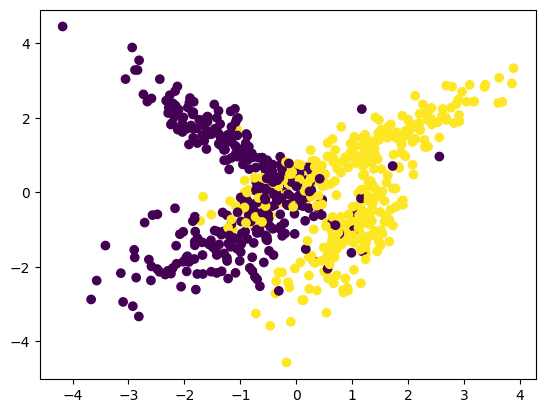

In [6]:
# Generamos los datos
x, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    random_state=10
)

# Separamos los datos en entrenamiento y evalucación 70-30
x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.3)
print(x_train.shape)

# Graficamos
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
plt.show()

Realizamos la regresión logística utilizando como método de aprendizaje el descenso por gradiente $ w \leftarrow w - \eta \nabla R$

In [7]:
pre = PreActivation(2,1) # Nodo de preactivación de dos variables y un bias
sig = Sigmoid(pre) # Nodo Sigmoide
criterion = BinaryCrossEntropy(sig)

epochs = 100
lr = 0.1 # Tasa de aprendizaje

# Descenso por Gradiente
for t in tqdm(range(epochs)):
    for x_i, y_i in zip(x_train, y_train):
        pred = sig.forward(x_i)
        criterion.forward(pred,y_i)
        a = criterion.backward()
        pre.w -= a.grad_w *lr
        pre.b -= a.grad_b *lr


100%|██████████| 100/100 [00:00<00:00, 130.69it/s]


#### Pregunta 6
Evaluamos qué tan bien hecha está la clasificación de los datos. Notemos que justamente tenemos una precisón superior a 0.85 en general, al igual que con el recall

In [8]:
y_pred = [sig.forward(x_i).out for x_i in x_eval]
print(classification_report(y_pred, y_eval))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       144
           1       0.93      0.82      0.87       156

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



Graficamos la clasificación para poder observar qué tan bien hecha está

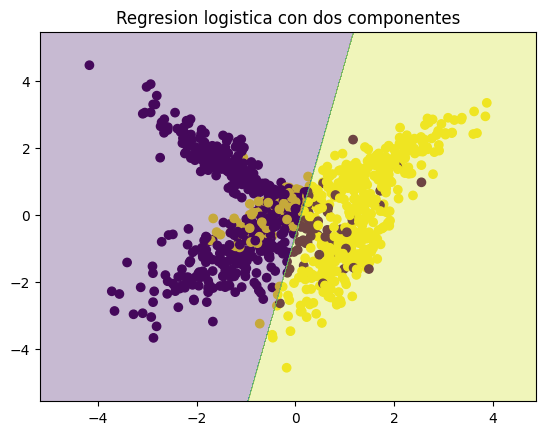

In [9]:
plt.scatter(x[:, 0], x[:, 1], c=y)

plt.title("Regresion logistica con dos componentes")

x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), 
                     np.linspace(y_min, y_max, 1000))

Z = [sig.forward(x_i).out for x_i in np.c_[xx.ravel(), yy.ravel()]]
Z = np.array(Z)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)

plt.show()

#### Pregunta 7
Definimos la clase para el perceptron, con la función escalonada $f(x) = \begin{cases} 1 \; , w \cdot x + b \geq 0 \\ 0 \; , w \cdot x + b < 0  \end{cases}$ 

Evaluamos el resultado utilizando los pesos aprendidos con anterioridad. Y vemos que en efecto la clasificación es la misma, tenemos el mismo número de clasificaciones de ambos casos, mismo recall y precisión

In [10]:
class Perceptron(Node):
    # Preceptron
    def __init__(self, node):
        self.preactivacion = node
    def forward(self, x):
        self.input = x
        self.wsum = self.preactivacion.forward(x).out # Definimos la preactivación lineal
        if (self.wsum>=0):
            self.out = 1
        else:
            self.out = 0
        return self
        
perc = Perceptron(pre) # Generamos el precpetrón con la preactivación previa
y_pred = [perc.forward(x_i).out for x_i in x_eval]
print(classification_report(y_pred, y_eval)) # Vemos la clasificación

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       144
           1       0.93      0.82      0.87       156

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



#### Pregunta 8
Definimos el error cuadrático, para poder realizar una regresión lineal, pues éste es su función objetivo. Al igual que la entropía binaria cruzada, esta clase supone que tenrá una preactivación.

In [11]:
class SquareError(Node):
    def __init__(self, node):
        self.activacion =  node
    
    def forward(self,x,y):
        self.pred, self.y = x,y;
        self.out = ((self.pred.out - self.y)**2)/2 # Definición del error cuadrático
        return
        
    def backward(self):
        # Derivada del error cuadrático
        self.grad = (self.pred.out - self.y)
        return self.activacion.backward(consumer_grad=self.grad)




Generamos nuevamente datos para la regresión lineal. Separamos en entrenamiento y evaluación 70-30 

In [12]:
x, y = make_regression(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    noise= 0.3
)
x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.3)


Graficamos los datos en 3D

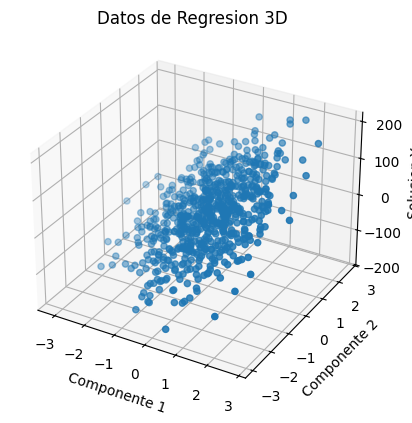

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], y_train)

ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Solucion Y")
plt.title("Datos de Regresion 3D ")

plt.show()

Realizamos el entrenamiento. Usamos el descenso por gradiente para aprender los pesos y el bias adecuado.

In [14]:
linreg = PreActivation(2,1) # Funcíon de activación
criterion = SquareError(linreg) # Función objetivo


print("Pesos y bias antes del aprendizaje",linreg.w,linreg.b) 

epochs = 100 # Número de épocas
lr = 0.1 # Tasa de aprendizaje
for t in tqdm(range(epochs)):
    for x_i, y_i in zip(x_train, y_train):
        pred = linreg.forward(x_i)
        criterion.forward(pred,y_i)
        R = criterion.backward()
        # Descenso por gradiente
        linreg.w -= R.grad_w *lr
        linreg.b -= R.grad_b *lr

# Mostramos los pesos y el bias
print("Pesos y bias después del aprendizje", linreg.w,linreg.b) 

Pesos y bias antes del aprendizaje [0.25590849 0.2305942 ] 0.9405724406607198


100%|██████████| 100/100 [00:00<00:00, 193.58it/s]

Pesos y bias después del aprendizje [30.99715883 59.60546726] 0.07470485408162861


Evaluamos el aprendizaje utilizando las funciones de MSE y R2 como criterios

In [15]:
y_pred = [linreg.forward(x_i).out for x_i in x_eval]

print(f'MSE: {mean_squared_error(y_pred, y_eval)}')
print(f'R2E: {r2_score(y_pred, y_eval)}')

MSE: 0.09444961881871165
R2E: 0.9999808557252726


Finalmente graficamos los datos en 3D junto con el plano que nos arroja la regresión lineal

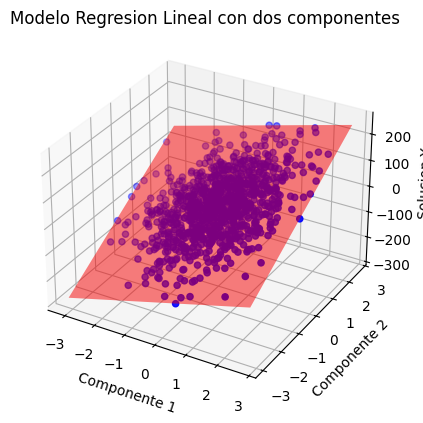

In [16]:
# Generamos el canvas
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficamos los datos
ax.scatter(x[:, 0], x[:, 1], y, color='blue', label='Data points')

# Graficamos el plano
x1 = np.linspace(x[:, 0].min(), x[:, 0].max(), 10)
x2 = np.linspace(x[:, 1].min(), x[:, 1].max(), 10)
x1, x2 = np.meshgrid(x1, x2)
y_pred_plane = linreg.w[0] * x1 + linreg.w[1] * x2 + linreg.b

ax.plot_surface(x1, x2, y_pred_plane, color='red', alpha=0.5, rstride=100, cstride=100)

# Nombramos los ejes y ponemos título
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Solucion Y")
plt.title("Modelo Regresion Lineal con dos componentes")

plt.show()